# Interpreting Bi-LSTM Sentiment Classification Models With Integrated Gradients

This notebook loads the pretrained Bi-LSTM model given by [PaddlePaddle Models](https://github.com/PaddlePaddle/models/tree/release/1.7) and performs sentiment analysis on reviews data. The full official PaddlePaddle sentiment classification tutorial can be found [here](https://github.com/PaddlePaddle/models/tree/release/1.7/PaddleNLP/sentiment_classification). 

Interpretations of the predictions are generated and visualized using Integrated Gradients algorithm, specifically the `IntGradNLPInterpreter` class.

In [1]:
import paddle.fluid as fluid
import numpy as np
import os
import io
import interpretdl as it
from assets.bilstm import bilstm_net_emb
from interpretdl.data_processor.visualizer import VisualizationTextRecord, visualize_text

If you have't done so, please first download the pretrained model by running the cell below.

In [ ]:
# downloads and extracts the model to assets/
!wget https://baidu-nlp.bj.bcebos.com/sentiment_classification-1.0.0.tar.gz -P assets/
!tar -C assets/ -zxf assets/sentiment_classification-1.0.0.tar.gz

Load the word dict from the pretrained model path. Define the `unk_id` to be the word id for unknown token *\<unk\>*. Other possible choices include empty token *\"\"* and pad token *\<pad\>*.

In [2]:
def load_vocab(file_path):
    """
    load the given vocabulary
    """
    vocab = {}
    with io.open(file_path, 'r', encoding='utf8') as f:
        wid = 0
        for line in f:
            if line.strip() not in vocab:
                vocab[line.strip()] = wid
                wid += 1
    vocab["<unk>"] = len(vocab)
    return vocab

MODEL_PATH = "assets/senta_model/bilstm_model/"
PARAMS_PATH = os.path.join(MODEL_PATH, "params")
VOCAB_PATH = os.path.join(MODEL_PATH, "word_dict.txt")

word_dict = load_vocab(VOCAB_PATH)
unk_id = word_dict["<unk>"]

Define the paddle model that takes in *word_ids* and *alpha*, and outputs embeddings and prediction probabilities. 

**Note**: 
- Inside the function, *alpha* should be multiplied to embeddings because Integrated Gradients method requires calculating the path integral between the baseline (zeros) and the inputs (embeddings).
- Here `bilstm_net_emb` is modified from [bilstm_net](https://github.com/PaddlePaddle/models/blob/release/1.7/PaddleNLP/shared_modules/models/classification/nets.py) provided by PaddlePaddle Models. The embedding layer is moved out of the function and returned so that intermediate embeddings can be extracted and apply gradients on.

In [3]:
def paddle_model(word_ids, alpha):
    dict_dim = 1256606
    emb_dim = 128
    # embedding layer
    emb = fluid.embedding(input=word_ids, size=[dict_dim, emb_dim])
    emb *= alpha
    probs = bilstm_net_emb(emb, None, None, dict_dim, is_prediction=True)
    return emb, probs

Initialize the `IntGradNLPInterpreter`. 

In [4]:
ig = it.IntGradNLPInterpreter(paddle_model, PARAMS_PATH, True)

Define the reviews that we want to analyze. 

The reviews are selected from the sentiment classification dataset. You can download them by running the cell below.

In [ ]:
# downloads and extracts the dataset to assets/
!wget https://baidu-nlp.bj.bcebos.com/sentiment_classification-dataset-1.0.0.tar.gz -P assets/
!tar -C assets/ -zxf assets/sentiment_classification-dataset-1.0.0.tar.gz

Since the Bi-LSTM model takes fluid.LoDTensor as inputs, reviews are first converted to word ids and then to LoDTensor. For more information regarding LoDTensor, please refer to [the offical documentation](https://www.paddlepaddle.org.cn/documentation/docs/zh/beginners_guide/basic_concept/lod_tensor.html#cn-user-guide-lod-tensor).

In [5]:
reviews = [
    '交通 方便 ； 环境 很好 ； 服务态度 很好 房间 较小',
    '这本书 实在 太烂 了 , 什么 朗读 手册 , 一点 朗读 的 内容 都 没有 . 看 了 几页 就 不 想 看 下去 了 .'
]

reviews = [r.split() for r in reviews]

lod = []
for c in reviews:
    lod.append([word_dict.get(words, unk_id) for words in c])
base_shape = [[len(c) for c in lod]]
lod = np.array(sum(lod, []), dtype=np.int64)
data = fluid.create_lod_tensor(lod, base_shape, fluid.CPUPlace())

In the cell below, we `interpret` reviews and grab weights for each token.

Since the output gradients are not grouped by reviews due to the LoDTensor inputs, we use the LoD information to group them into a list of lists.

In [6]:
pred_labels, pred_probs, avg_gradients = ig.interpret(
    data, label=None, steps=50, return_pred=True, visual=True)

sum_gradients = np.sum(avg_gradients, axis=1).tolist()

lod = data.lod()
new_array = []
for i in range(len(lod[0]) - 1):
    new_array.append(
        list(zip(reviews[i], sum_gradients[lod[0][i]:lod[0][i + 1]])))

For visualizasion purposes, word weights in each review are normalized to better illustrate differences between weights. Results for each review is stored in a list by making use of the `VisualizationTextRecord`.

In [7]:
true_labels = [1, 0]
recs = []
for i, l in enumerate(new_array):
    words = [t[0] for t in l]
    word_importances = [t[1] for t in l]
    word_importances = np.array(word_importances) / np.linalg.norm(
        word_importances)
    pred_label = pred_labels[i]
    pred_prob = pred_probs[i]
    true_label = true_labels[i]
    interp_class = pred_label
    if interp_class == 0:
        word_importances = -word_importances
    recs.append(
        VisualizationTextRecord(words, word_importances, true_label,
                                pred_label, pred_prob, interp_class))

visualize_text(recs)

The above cell's output is similar to the following:

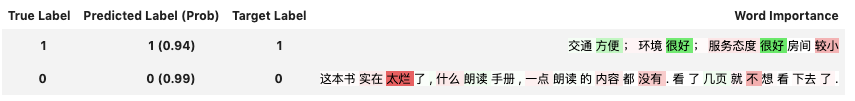

In [8]:
from IPython.display import Image
Image(filename='assets/nlp_visualization.png')